In [14]:
import matplotlib.pyplot as plt
import pandas as pd 

from gpt3forchem.data import get_bandgap_data
import numpy as np 
from sklearn.decomposition import PCA

from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit.Chem.Draw import IPythonConsole

from rdkit import DataStructs
from rdkit.Chem import AllChem
from glob import glob

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use(['science', 'nature'])
%matplotlib inline
class FP:
    """
    Molecular fingerprint class, useful to pack features in pandas df
    
    Parameters  
    ---------- 
    fp : np.array
        Features stored in numpy array
    names : list, np.array
        Names of the features
    """
    def __init__(self, fp, names):
        self.fp = fp
        self.names = names
    def __str__(self):
        return "%d bit FP" % len(self.fp)
    def __len__(self):
        return len(self.fp)

In [2]:
data = get_bandgap_data()

In [3]:
def get_cfps(smiles, radius=2, nBits=1024, useFeatures=False, counts=False, dtype=np.float32):
    """Calculates circular (Morgan) fingerprint.  
    http://rdkit.org/docs/GettingStartedInPython.html#morgan-fingerprints-circular-fingerprints  
    
    Parameters
    ----------
    smile : str
    radius : float 
        Fingerprint radius, default 2
    nBits : int 
        Length of hashed fingerprint (without descriptors), default 1024
    useFeatures : bool  
        To get feature fingerprints (FCFP) instead of normal ones (ECFP), defaults to False
    counts : bool
        If set to true it returns for each bit number of appearances of each substructure (counts). Defaults to false (fingerprint is binary)
    dtype : np.dtype
        Numpy data type for the array. Defaults to np.float32 because it is the default dtype for scikit-learn
    
    Returns
    -------
    ML.FP
        Fingerprint (feature) object
    """
    try:
        mol = Chem.MolFromSmiles(smiles)
        arr = np.zeros((1,), dtype)
        
        if counts is True:
            info = {}
            fp = AllChem.GetHashedMorganFingerprint(mol, radius, nBits, useFeatures=useFeatures)
            DataStructs.ConvertToNumpyArray(fp, arr)
        else:
            DataStructs.ConvertToNumpyArray(AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=nBits, useFeatures=useFeatures), arr)
        return FP(arr, range(nBits))
    except:
        return None

In [4]:
fingerprints = data['smiles'].map(get_cfps)

In [5]:
X = np.array([x.fp for x in fingerprints])

In [6]:
pca = PCA(n_components=2)
X_decomposed = pca.fit_transform(X)

In [7]:
plt.scatter(X_decomposed[:,0], X_decomposed[:,1])

In [8]:
def read_smiles_from_file(filename):
    """Reads smiles from file
    
    Parameters
    ----------
    filename : str
        Path to the file
    
    Returns
    -------
    list
        List of smiles
    """
    with open(filename, 'r') as f:
        smiles = f.read().splitlines()
    return smiles, float(filename.replace('.txt', '').split('_')[-1])

In [10]:
smiles_files = glob('for_xtb_opt/2022-11-27-22-29-4350000_smiles_*.txt')

In [11]:
fingerprints_at_t = {}
for smiles_file in smiles_files:
    if not "gaps" in smiles_file:
        try:
            smiles, t = read_smiles_from_file(smiles_file)
            fingerprints_at_t[t] = np.array([get_cfps(s).fp for s in smiles])
        except Exception as e:
            print(e)

In [62]:
#normalize item number values to colormap
norm = mpl.colors.Normalize(vmin=0, vmax=1.5)
norm_iterations = mpl.colors.Normalize(vmin=0, vmax=3)

In [25]:
random_samples = np.random.choice(range(len(X_decomposed)), 10_000)

In [37]:
initial_sample_for_bias = glob('for_more_xtb_opt/2022-12-07-15-51-30_smiles_extrapolation_sets*.txt') + glob('for_more_xtb_opt/2022-12-07-15-51-30_smiles_extrapolation*.txt')

In [47]:
iteration_1 = glob("for_more_xtb_opt/2022-12-09-23-20-30_smiles_iteration_1_biased_sets*.txt")

In [54]:
iteration_2 = glob("for_more_xtb_opt/2022-12-11-23-54-28_smiles_iteration_2_biased_sets*.txt")

In [56]:
def get_gp(files):
    initial_fingerprints = []
    for smiles_file in files:
        if not "gaps" in smiles_file:
            try:
                with open(smiles_file, 'r') as f:
                    smiles = f.read().splitlines()
                initial_fingerprints.extend([get_cfps(s).fp for s in smiles])
            except Exception as e:
                print(e)
    return initial_fingerprints

initial_fingerprints = get_gp(initial_sample_for_bias)
iteration_1_fingerprints = get_gp(iteration_1)
iteration_2_fingerprints = get_gp(iteration_2)

In [57]:
x_initial_fp_decomposed = pca.transform(initial_fingerprints)
x_iteration_1_fp_decomposed = pca.transform(iteration_1_fingerprints)
x_iteration_2_fp_decomposed = pca.transform(iteration_2_fingerprints)

In [69]:
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use(['science', 'nature'])

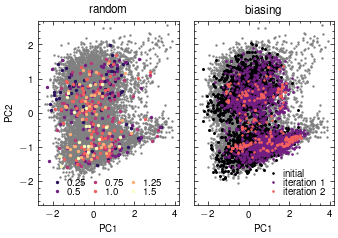

In [79]:
fig, ax = plt.subplots(1,2, sharex='all', sharey='all', figsize=(3.5, 2.5))

for a in ax:
    a.scatter(X_decomposed[random_samples,0], X_decomposed[random_samples,1], s=.5, c='gray')


for t in [0.25, 0.5, 0.75, 1.0, 1.25, 1.5]:
    X = fingerprints_at_t[t]
    x_fp = pca.transform(X)
    ax[0].scatter(x_fp[:,0], x_fp[:,1], label=t, color = mpl.cm.magma(norm(t)), s=2 )

ax[0].set_title('random')
ax[0].legend(ncol=3, columnspacing=0, handletextpad=0, labelspacing=0)
ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')

ax[1].set_xlabel('PC1')
ax[1].set_title('biasing')

ax[1].scatter(x_initial_fp_decomposed[:,0], x_initial_fp_decomposed[:,1], s=.8, label='initial', color = mpl.cm.magma(norm_iterations(0)))
ax[1].scatter(x_iteration_1_fp_decomposed[:,0], x_iteration_1_fp_decomposed[:,1], s=.8, label='iteration 1', color = mpl.cm.magma(norm_iterations(1)))
ax[1].scatter(x_iteration_2_fp_decomposed[:,0], x_iteration_2_fp_decomposed[:,1], s=.8, label='iteration 2', color = mpl.cm.magma(norm_iterations(2)))
ax[1].legend(columnspacing=0, handletextpad=0, labelspacing=0)

ax[1].set_ylim(-2.7, 2.7)
fig.tight_layout()
fig.savefig('chemical_space_inverse.pdf', bbox_inches='tight')